# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [9]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
from timeit import default_timer as timer
from datetime import timedelta

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
tf.random.set_seed(30)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [3]:
def generator(source_path, folder_list, batch_size=10, frames = 30, image_height=100, image_width=100, channels = 3):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0, frames)]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, frames, image_width, image_width, channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image_resized=imresize(image,(image_height, image_width, channels))
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        remaining_seq=len(t)%batch_size
        
        if (remaining_seq != 0):
            batch_data = np.zeros((remaining_seq, frames, image_width, image_width, channels))
            batch_labels = np.zeros((remaining_seq,5))
            
            for folder in range(remaining_seq): # iterate over the remaining images
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*remaining_seq)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*remaining_seq)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image_resized=imresize(image,(image_height, image_width, channels))
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (num_batches*remaining_seq)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [4]:
def train_model(dl_model, batch_size=50, num_epochs = 1, frames = 30, image_height=100, image_width=100, channels = 3):
    
    start = round(timer())
    
    train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
    val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
    
    curr_dt_time = datetime.datetime.now()
    train_path = 'Project_data/train'
    val_path = 'Project_data/val'
    num_train_sequences = len(train_doc)
    print('# training sequences =', num_train_sequences)
    num_val_sequences = len(val_doc)
    print('# validation sequences =', num_val_sequences)
    
    print ('# epochs =', num_epochs)

    train_generator = generator(train_path, train_doc, batch_size, frames, image_height, image_width, channels)
    val_generator = generator(val_path, val_doc, batch_size, frames, image_height, image_width, channels)

    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

    #LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
    callbacks_list = [checkpoint, LR]

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    hist = dl_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    
    end = round(timer())
    time_elapsed = timedelta(seconds=end-start)
    print("=" * 100)
    print(f"Time for Training: {time_elapsed}")
    print("=" * 100)
    
    print(hist)
    return hist, time_elapsed

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    
results = []

# Models
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Test Conv3D Model

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

def create_Conv3D_test_model(filtersize=(3,3,3),dense_neurons=64,dropout=0.25, 
                        num_classes = 5, frames=30, image_height=100, image_width=100, channels=3):

    model = Sequential()
    model.add(Conv3D(16, filtersize, padding='same',
             input_shape=(frames,image_height,image_width,channels)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(dense_neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes,activation='softmax'))

    optimiser = optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

## Test Model 1 - Batch Size : 10 Image Size: (100 x 100)

In [7]:
filtersize=(3,3,3)
dense_neurons=16
dropout=0.25

num_classes=5
frames=30
image_height=100
image_width=100
channels=3

batch_size=10
num_epochs = 5

dl_model = create_Conv3D_test_model(filtersize, dense_neurons, dropout,
                               num_classes, frames, image_height, image_width, channels)

hist, time_elapsed = train_model(dl_model, batch_size=batch_size, num_epochs = num_epochs,
                                frames=frames, image_height=image_height, image_width=image_width, channels=channels)

results.append({'params':(num_classes, frames, image_height, image_width, channels, batch_size),
                "hist":hist, 
                "time_elapsed":time_elapsed
               })

W0502 08:55:35.124202 140651016116032 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


# training sequences = 663
# validation sequences = 100
# epochs = 5
Source path =  Project_data/train ; batch size = 10


/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Epoch 1/5
65/67 [============================>.] - ETA: 5s - loss: 1.4727 - categorical_accuracy: 0.4123

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


67/67 [==============================] - ETA: 0s - loss: 1.4653 - categorical_accuracy: 0.4118Source path =  Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2021-05-0208_55_35.108623/model-00001-1.46531-0.41176-5.70784-0.26000.h5
67/67 [==============================] - 227s 3s/step - loss: 1.4653 - categorical_accuracy: 0.4118 - val_loss: 5.7078 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/5
67/67 [==============================] - ETA: 0s - loss: 1.0235 - categorical_accuracy: 0.6280
Epoch 00002: saving model to model_init_2021-05-0208_55_35.108623/model-00002-1.02347-0.62805-19.01862-0.15000.h5
67/67 [==============================] - 93s 1s/step - loss: 1.0235 - categorical_accuracy: 0.6280 - val_loss: 19.0186 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/5
67/67 [==============================] - ETA: 0s - loss: 0.8562 - categorical_accuracy: 0.7026
Epoch 00003: saving model to model_init_2021-05-0208_55_35.108623/model-00003-0.8562

KeyboardInterrupt: 

## Test Model 2 - Batch Size : 10 Image Size: (160 x 160)

In [8]:
filtersize=(3,3,3)
dense_neurons=16
dropout=0.25

num_classes=5
frames=30
image_height=160
image_width=160
channels=3

batch_size=10
num_epochs = 1

dl_model = create_Conv3D_test_model(filtersize, dense_neurons, dropout,
                               num_classes, frames, image_height, image_width, channels)

hist, time_elapsed = train_model(dl_model, batch_size=batch_size, num_epochs = num_epochs,
                                frames=frames, image_height=image_height, image_width=image_width, channels=channels)

results.append({'params':(num_classes, frames, image_height, image_width, channels, batch_size),
                "hist":hist, 
                "time_elapsed":time_elapsed
               })

W0429 15:37:32.139760 139878492301120 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


# training sequences = 663
# validation sequences = 100
# epochs = 1
Source path =  Project_data/train ; batch size = 10


/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


67/67 [==============================] - ETA: 0s - loss: 1.4782 - categorical_accuracy: 0.3776 Source path =  Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2021-04-2915_37_32.138703/model-00001-1.47817-0.37761-4.07185-0.27000.h5
67/67 [==============================] - 1725s 26s/step - loss: 1.4782 - categorical_accuracy: 0.3776 - val_loss: 4.0719 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Time for Training: 0:29:14


## Test Model 3 - Batch Size : 50 Image Size: (100 x 100)

In [9]:
filtersize=(3,3,3)
dense_neurons=16
dropout=0.25

num_classes=5
frames=30
image_height=100
image_width=100
channels=3

batch_size=50
num_epochs = 1

dl_model = create_Conv3D_test_model(filtersize, dense_neurons, dropout,
                               num_classes, frames, image_height, image_width, channels)

hist, time_elapsed = train_model(dl_model, batch_size=batch_size, num_epochs = num_epochs,
                                frames=frames, image_height=image_height, image_width=image_width, channels=channels)

results.append({'params':(num_classes, frames, image_height, image_width, channels, batch_size),
                "hist":hist, 
                "time_elapsed":time_elapsed
               })

W0429 16:06:46.438178 139878492301120 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


# training sequences = 663
# validation sequences = 100
# epochs = 1
Source path =  Project_data/train ; batch size = 50


/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


14/14 [==============================] - ETA: 0s - loss: 1.5801 - categorical_accuracy: 0.4157 Source path =  Project_data/val ; batch size = 50

Epoch 00001: saving model to model_init_2021-04-2916_06_46.436990/model-00001-1.58011-0.41571-2.02008-0.23000.h5
14/14 [==============================] - 691s 49s/step - loss: 1.5801 - categorical_accuracy: 0.4157 - val_loss: 2.0201 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Time for Training: 0:12:34


## Test Model 4 - Batch Size : 50 Image Size: (160,160)

In [ ]:
filtersize=(3,3,3)
dense_neurons=16
dropout=0.25

num_classes=5
frames=30
image_height=160
image_width=160
channels=3

batch_size=50
num_epochs = 1

dl_model = create_Conv3D_test_model(filtersize, dense_neurons, dropout,
                               num_classes, frames, image_height, image_width, channels)

hist, time_elapsed = train_model(dl_model, batch_size=batch_size, num_epochs = num_epochs,
                                frames=frames, image_height=image_height, image_width=image_width, channels=channels)

results.append({'params':(num_classes, frames, image_height, image_width, channels, batch_size),
                "hist":hist, 
                "time_elapsed":time_elapsed
               })

W0430 04:20:39.589228 140415793997632 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


# training sequences = 663
# validation sequences = 100
# epochs = 1
Source path =  Project_data/train ; batch size = 50


/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


## Cov2D-LSTM Model

In [7]:
from keras.layers.recurrent import LSTM
from keras.layers.convolutional import Conv2D, MaxPooling2D

def create_Conv2D_LSTM_model(filtersize=(3,3),dense_neurons=64,dropout=0.25, lstm_cells=64,
                        num_classes = 5, frames=30, image_height=100, image_width=100, channels=3):

    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                              input_shape=(frames, image_height, image_width, channels)))
    #model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
    #model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    #model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    #model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
    #model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
    # model.add(TimeDistributed(BatchNormalization()))
    # model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))


    model.add(LSTM(lstm_cells))
    model.add(Dropout(dropout))

    model.add(Dense(dense_neurons,activation='relu'))
    model.add(Dropout(dropout))

    model.add(Dense(num_classes, activation='softmax'))
    optimiser = optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    print (model.summary())
    return model

W0502 15:30:04.807165 140627641685824 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 30, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 25, 25, 64)    18496     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 12, 12, 64)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 12, 12, 128)   7

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Epoch 1/25
12/14 [========================>.....] - ETA: 26s - loss: 1.6176 - categorical_accuracy: 0.2033

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


14/14 [==============================] - ETA: 0s - loss: 1.5869 - categorical_accuracy: 0.2081 Source path =  Project_data/val ; batch size = 50

Epoch 00001: saving model to model_init_2021-05-0215_30_04.784986/model-00001-1.58686-0.20814-1.60059-0.23000.h5
14/14 [==============================] - 217s 15s/step - loss: 1.5869 - categorical_accuracy: 0.2081 - val_loss: 1.6006 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
14/14 [==============================] - ETA: 0s - loss: 1.1969 - categorical_accuracy: 0.3047
Epoch 00002: saving model to model_init_2021-05-0215_30_04.784986/model-00002-1.19694-0.30469-1.60288-0.31000.h5
14/14 [==============================] - 37s 3s/step - loss: 1.1969 - categorical_accuracy: 0.3047 - val_loss: 1.6029 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 3/25
14/14 [==============================] - ETA: 0s - loss: 1.5175 - categorical_accuracy: 0.2190
Epoch 00003: saving model to model_init_2021-05-0215_30_04.784986/model-00003-1.51

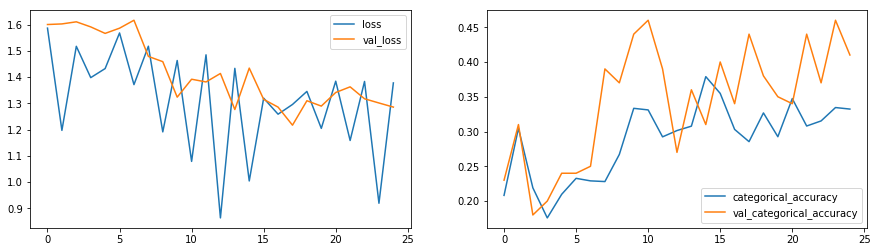

In [8]:
filtersize=(3,3)
dense_neurons=32
dropout=0.25

num_classes=5
frames=30
image_height=100
image_width=100
channels=3

lstm_cells=64

batch_size=50
num_epochs = 25

dl_model = create_Conv2D_LSTM_model(filtersize, dense_neurons, dropout, lstm_cells,
                               num_classes, frames, image_height, image_width, channels)

hist, time_elapsed = train_model(dl_model, batch_size=batch_size, num_epochs = num_epochs,
                                frames=frames, image_height=image_height, image_width=image_width, channels=channels)

results.append({'params':(num_classes, frames, image_height, image_width, channels, batch_size),
                "hist":hist, 
                "time_elapsed":time_elapsed
               })

plot(hist)

## Conv3D Model

In [10]:
def create_Conv3D_model(filtersize=(3,3,3),dense_neurons=64,dropout=0.25, 
                        num_classes = 5, frames=30, image_height=100, image_width=100, channels=3):

    model = Sequential()
    model.add(Conv3D(16, filtersize, padding='same',
             input_shape=(frames,image_height,image_width,channels)))
    model.add(Activation('relu'))
    #model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, filtersize, padding='same'))
    model.add(Activation('relu'))
    #model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, filtersize, padding='same'))
    model.add(Activation('relu'))
    #model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, filtersize, padding='same'))
    model.add(Activation('relu'))
    #model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(dense_neurons,activation='relu'))
    #model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_neurons,activation='relu'))
    #model.add(BatchNormalization())
    model.add(Dropout(dropout))


    model.add(Dense(num_classes,activation='softmax'))

    optimiser = optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

## Model Ver 1 - Conv3D with filtersize (3,3,3)

In [ ]:
filtersize=(3,3,3)
dense_neurons=64
dropout=0.25

num_classes=5
frames=20
image_height=160
image_width=160
channels=3

batch_size=40
num_epochs = 25

dl_model = create_Conv3D_model(filtersize, dense_neurons, dropout,
                               num_classes, frames, image_height, image_width, channels)

hist, time_elapsed = train_model(dl_model, batch_size=batch_size, num_epochs = num_epochs,
                                frames=frames, image_height=image_height, image_width=image_width, channels=channels)

results.append({'params':(num_classes, frames, image_height, image_width, channels, batch_size),
                "hist":hist, 
                "time_elapsed":time_elapsed
               })

plot(hist)

W0502 15:59:41.474117 140627641685824 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


# training sequences = 663
# validation sequences = 100
# epochs = 25
Source path =  Project_data/train ; batch size = 40


/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Epoch 1/25
15/17 [=========================>....] - ETA: 17s - loss: 1.6039 - categorical_accuracy: 0.1967

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


17/17 [==============================] - ETA: 0s - loss: 1.5479 - categorical_accuracy: 0.1900Source path =  Project_data/val ; batch size = 40

Epoch 00001: saving model to model_init_2021-05-0215_59_41.427295/model-00001-1.54789-0.19005-1.20533-0.17000.h5
17/17 [==============================] - 161s 9s/step - loss: 1.5479 - categorical_accuracy: 0.1900 - val_loss: 1.2053 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/25
17/17 [==============================] - ETA: 0s - loss: 0.5287 - categorical_accuracy: 0.1918
Epoch 00002: saving model to model_init_2021-05-0215_59_41.427295/model-00002-0.52868-0.19182-0.24763-0.10000.h5
17/17 [==============================] - 15s 880ms/step - loss: 0.5287 - categorical_accuracy: 0.1918 - val_loss: 0.2476 - val_categorical_accuracy: 0.1000 - lr: 0.0010
Epoch 3/25
17/17 [==============================] - ETA: 0s - loss: 1.4347 - categorical_accuracy: 0.3546
Epoch 00003: saving model to model_init_2021-05-0215_59_41.427295/model-00003-1.4

## Model Ver 2 - Conv3D with filtersize (2,2,2)

W0430 13:06:16.445255 139833732212544 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


# training sequences = 663
# validation sequences = 100
# epochs = 25
Source path =  Project_data/train ; batch size = 50


/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Epoch 1/25
14/14 [==============================] - ETA: 0s - loss: 1.7046 - categorical_accuracy: 0.3800 Source path =  Project_data/val ; batch size = 50

Epoch 00001: saving model to model_init_2021-04-3013_06_16.406132/model-00001-1.70457-0.38000-1.72123-0.16000.h5
14/14 [==============================] - 225s 16s/step - loss: 1.7046 - categorical_accuracy: 0.3800 - val_loss: 1.7212 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
14/14 [==============================] - ETA: 0s - loss: 0.9903 - categorical_accuracy: 0.6200
Epoch 00002: saving model to model_init_2021-04-3013_06_16.406132/model-00002-0.99030-0.62000-2.68622-0.15000.h5
14/14 [==============================] - 98s 7s/step - loss: 0.9903 - categorical_accuracy: 0.6200 - val_loss: 2.6862 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/25
14/14 [==============================] - ETA: 0s - loss: 0.7759 - categorical_accuracy: 0.7071
Epoch 00003: saving model to model_init_2021-04-3013_06_16.406132/model

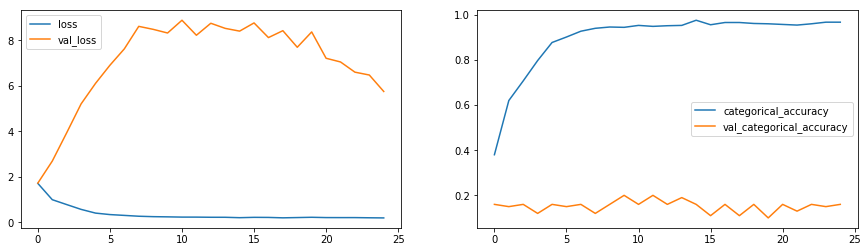

In [8]:
filtersize=(2,2,2)
dense_neurons=64
dropout=0.25

num_classes=5
frames=30
image_height=100
image_width=100
channels=3

lstm_cells=64

batch_size=50
num_epochs = 25

dl_model = create_Conv3D_model(filtersize, dense_neurons, dropout,
                               num_classes, frames, image_height, image_width, channels)

hist, time_elapsed = train_model(dl_model, batch_size=batch_size, num_epochs = num_epochs,
                                frames=frames, image_height=image_height, image_width=image_width, channels=channels)

results.append({'params':(num_classes, frames, image_height, image_width, channels, batch_size),
                "hist":hist, 
                "time_elapsed":time_elapsed
               })

plot(hist)

## Large Conv3D Model

In [7]:
def create_Conv3D_large_model(filtersize=(3,3,3),dense_neurons=64,dropout=0.25, 
                        num_classes = 5, frames=30, image_height=100, image_width=100, channels=3):

    model = Sequential()
    model.add(Conv3D(16, filtersize, padding='same',
             input_shape=(frames,image_height,image_width,channels)))
    model.add(Activation('relu'))
    #model.add(BatchNormalization())

    model.add(Conv3D(16, filtersize, padding='same',
             input_shape=(frames,image_height,image_width,channels)))
    model.add(Activation('relu'))
    #model.add(BatchNormalization())

    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, filtersize, padding='same'))
    model.add(Activation('relu'))
    #model.add(BatchNormalization())

    model.add(Conv3D(32, filtersize, padding='same'))
    model.add(Activation('relu'))
    #model.add(BatchNormalization())

    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, filtersize, padding='same'))
    model.add(Activation('relu'))
    #model.add(BatchNormalization())

    model.add(Conv3D(64, filtersize, padding='same'))
    model.add(Activation('relu'))
    #model.add(BatchNormalization())

    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, filtersize, padding='same'))
    model.add(Activation('relu'))
    #model.add(BatchNormalization())

    model.add(Conv3D(128, filtersize, padding='same'))
    model.add(Activation('relu'))
    #model.add(BatchNormalization())

    model.add(MaxPooling3D(pool_size=(2, 2, 2)))


    model.add(Flatten())
    model.add(Dense(dense_neurons,activation='relu'))
    #model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_neurons,activation='relu'))
    #model.add(BatchNormalization())
    model.add(Dropout(dropout))


    model.add(Dense(num_classes,activation='softmax'))

    optimiser = optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

## Model Ver 3 - Large Conv3D with filtersize (3,3,3)

W0502 12:50:10.323363 140650824443712 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


# training sequences = 663
# validation sequences = 100
# epochs = 15
Source path =  Project_data/train ; batch size = 20


/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Epoch 1/15
32/34 [===========================>..] - ETA: 9s - loss: 1.6473 - categorical_accuracy: 0.1875 

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


34/34 [==============================] - ETA: 0s - loss: 1.6409 - categorical_accuracy: 0.1885Source path =  Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2021-05-0212_50_10.287045/model-00001-1.64085-0.18854-1.60499-0.23000.h5
34/34 [==============================] - 193s 6s/step - loss: 1.6409 - categorical_accuracy: 0.1885 - val_loss: 1.6050 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.6035 - categorical_accuracy: 0.1935
Epoch 00002: saving model to model_init_2021-05-0212_50_10.287045/model-00002-1.60351-0.19350-1.57810-0.22000.h5
34/34 [==============================] - 96s 3s/step - loss: 1.6035 - categorical_accuracy: 0.1935 - val_loss: 1.5781 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 1.5878 - categorical_accuracy: 0.2035
Epoch 00003: saving model to model_init_2021-05-0212_50_10.287045/model-00003-1.5878

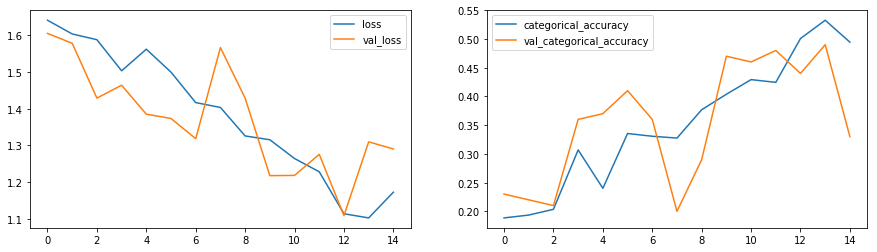

In [8]:
filtersize=(3,3,3)
dense_neurons=64
dropout=0.25

num_classes=5
frames=20
image_height=160
image_width=160
channels=3

batch_size=20
num_epochs = 15

dl_model = create_Conv3D_large_model(filtersize, dense_neurons, dropout,
                               num_classes, frames, image_height, image_width, channels)

hist, time_elapsed = train_model(dl_model, batch_size=batch_size, num_epochs = num_epochs,
                                frames=frames, image_height=image_height, image_width=image_width, channels=channels)

results.append({'params':(num_classes, frames, image_height, image_width, channels, batch_size),
                "hist":hist, 
                "time_elapsed":time_elapsed
               })

plot(hist)

## Model Ver 4 - Large Conv3D with filtersize (2,2,2)

In [ ]:
filtersize=(3,3,3)
dense_neurons=64
dropout=0.25

num_classes=5
frames=30
image_height=160
image_width=160
channels=3

batch_size=30
num_epochs = 25

dl_model = create_Conv3D_large_model(filtersize, dense_neurons, dropout,
                               num_classes, frames, image_height, image_width, channels)

hist, time_elapsed = train_model(dl_model, batch_size=batch_size, num_epochs = num_epochs,
                                frames=frames, image_height=image_height, image_width=image_width, channels=channels)

results.append({'params':(num_classes, frames, image_height, image_width, channels, batch_size),
                "hist":hist, 
                "time_elapsed":time_elapsed
               })

plot(hist)

W0502 13:40:50.611897 140650824443712 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


# training sequences = 663
# validation sequences = 100
# epochs = 25
Source path =  Project_data/train ; batch size = 30


/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Epoch 1/25
21/23 [==========================>...] - ETA: 15s - loss: 1.6110 - categorical_accuracy: 0.1905

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


23/23 [==============================] - ETA: 0s - loss: 1.6059 - categorical_accuracy: 0.1870Source path =  Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2021-05-0213_40_50.582024/model-00001-1.60590-0.18703-1.42827-0.21000.h5
23/23 [==============================] - 221s 10s/step - loss: 1.6059 - categorical_accuracy: 0.1870 - val_loss: 1.4283 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.6325 - categorical_accuracy: 0.2201
Epoch 00002: saving model to model_init_2021-05-0213_40_50.582024/model-00002-1.63254-0.22013-0.72452-0.05000.h5
23/23 [==============================] - 219s 10s/step - loss: 1.6325 - categorical_accuracy: 0.2201 - val_loss: 0.7245 - val_categorical_accuracy: 0.0500 - lr: 0.0010
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.6011 - categorical_accuracy: 0.1905
Epoch 00003: saving model to model_init_2021-05-0213_40_50.582024/model-00003-1.6

## Large Conv3D Model with Dropout (in Conv Layer)

In [7]:
def create_Conv3D_large_dropout_model(filtersize=(3,3,3),dense_neurons=64,dropout=0.25, 
                        num_classes = 5, frames=30, image_height=100, image_width=100, channels=3):

    model = Sequential()
    model.add(Conv3D(16, filtersize, padding='same',
             input_shape=(frames,image_height,image_width,channels)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv3D(16, filtersize, padding='same',
             input_shape=(frames,image_height,image_width,channels)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(dropout))

    model.add(Conv3D(32, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv3D(32, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(dropout))

    model.add(Conv3D(64, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv3D(64, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(dropout))

    model.add(Conv3D(128, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv3D(128, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(dense_neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))


    model.add(Dense(num_classes,activation='softmax'))

    optimiser = optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

## Model Ver 5 - Large Conv3D (Dropout) with filtersize (3,3,3)

W0501 07:18:23.757009 140211332187968 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


# training sequences = 663
# validation sequences = 100
# epochs = 25
Source path =  Project_data/train ; batch size = 50


/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Epoch 1/25
14/14 [==============================] - ETA: 0s - loss: 1.8442 - categorical_accuracy: 0.3057 Source path =  Project_data/val ; batch size = 50

Epoch 00001: saving model to model_init_2021-05-0107_18_23.714012/model-00001-1.84417-0.30571-1.63050-0.23000.h5
14/14 [==============================] - 216s 15s/step - loss: 1.8442 - categorical_accuracy: 0.3057 - val_loss: 1.6305 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
14/14 [==============================] - ETA: 0s - loss: 1.4024 - categorical_accuracy: 0.4329
Epoch 00002: saving model to model_init_2021-05-0107_18_23.714012/model-00002-1.40243-0.43286-2.32082-0.25000.h5
14/14 [==============================] - 97s 7s/step - loss: 1.4024 - categorical_accuracy: 0.4329 - val_loss: 2.3208 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/25
14/14 [==============================] - ETA: 0s - loss: 1.1234 - categorical_accuracy: 0.5186
Epoch 00003: saving model to model_init_2021-05-0107_18_23.714012/model

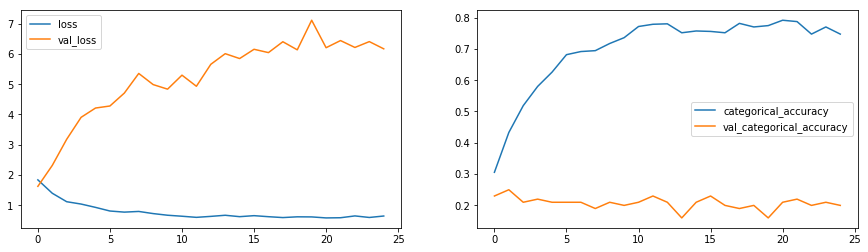

In [8]:
filtersize=(3,3,3)
dense_neurons=64
dropout=0.25

num_classes=5
frames=30
image_height=100
image_width=100
channels=3

batch_size=50
num_epochs = 25

dl_model = create_Conv3D_large_dropout_model(filtersize, dense_neurons, dropout,
                               num_classes, frames, image_height, image_width, channels)

hist, time_elapsed = train_model(dl_model, batch_size=batch_size, num_epochs = num_epochs,
                                frames=frames, image_height=image_height, image_width=image_width, channels=channels)

results.append({'params':(num_classes, frames, image_height, image_width, channels, batch_size),
                "hist":hist, 
                "time_elapsed":time_elapsed
               })

plot(hist)

## Model Ver 6 - Large Conv3D (Dropout) with filtersize (2,2,2)

In [ ]:
filtersize=(2,2,2)
dense_neurons=64
dropout=0.25

num_classes=5
frames=30
image_height=100
image_width=100
channels=3

batch_size=50
num_epochs = 25

dl_model = create_Conv3D_large_dropout_model(filtersize, dense_neurons, dropout,
                               num_classes, frames, image_height, image_width, channels)

hist, time_elapsed = train_model(dl_model, batch_size=batch_size, num_epochs = num_epochs,
                                frames=frames, image_height=image_height, image_width=image_width, channels=channels)

results.append({'params':(num_classes, frames, image_height, image_width, channels, batch_size),
                "hist":hist, 
                "time_elapsed":time_elapsed
               })

plot(hist)

## Conv3D Model with Reduced Parameters 1

In [9]:
def create_Conv3D_small_model(filtersize=(3,3,3),dense_neurons=64,dropout=0.25, 
                        num_classes = 5, frames=30, image_height=100, image_width=100, channels=3):

    model = Sequential()
    model.add(Conv3D(16, (3, 3, 3), padding='same',
             input_shape=(frames,image_height,image_width,channels)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(dense_neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes,activation='softmax'))

    optimiser = optimizers.Adam(lr=0.0002)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

## Model Ver 7 - Conv3D (Reduced Parameters 1) with filtersize (3,3,3)

In [ ]:
filtersize=(3,3,3)
dense_neurons=64
dropout=0.25

num_classes=5
frames=30
image_height=100
image_width=100
channels=3

lstm_cells=64

batch_size=50
num_epochs = 25

dl_model = create_Conv3D_small_model(filtersize, dense_neurons, dropout,
                               num_classes, frames, image_height, image_width, channels)

hist, time_elapsed = train_model(dl_model, batch_size=batch_size, num_epochs = num_epochs,
                                frames=frames, image_height=image_height, image_width=image_width, channels=channels)

results.append({'params':(num_classes, frames, image_height, image_width, channels, batch_size),
                "hist":hist, 
                "time_elapsed":time_elapsed
               })

plot(hist)

W0501 14:09:50.161470 140052999092032 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


# training sequences = 663
# validation sequences = 100
# epochs = 25
Source path =  Project_data/train ; batch size = 50


/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Epoch 1/25
12/14 [========================>.....] - ETA: 1:36 - loss: 1.9492 - categorical_accuracy: 0.2750

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


14/14 [==============================] - ETA: 0s - loss: 1.9035 - categorical_accuracy: 0.2836 Source path =  Project_data/val ; batch size = 50

Epoch 00001: saving model to model_init_2021-05-0114_09_50.148908/model-00001-1.90346-0.28356-1.61036-0.21000.h5
14/14 [==============================] - 692s 49s/step - loss: 1.9035 - categorical_accuracy: 0.2836 - val_loss: 1.6104 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
14/14 [==============================] - ETA: 0s - loss: 0.8577 - categorical_accuracy: 0.3867 
Epoch 00002: saving model to model_init_2021-05-0114_09_50.148908/model-00002-0.85766-0.38672-1.62880-0.26000.h5
14/14 [==============================] - 277s 20s/step - loss: 0.8577 - categorical_accuracy: 0.3867 - val_loss: 1.6288 - val_categorical_accuracy: 0.2600 - lr: 2.0000e-04
Epoch 3/25
14/14 [==============================] - ETA: 0s - loss: 1.3117 - categorical_accuracy: 0.4312 
Epoch 00003: saving model to model_init_2021-05-0114_09_50.148908/mode

Epoch 20/25
14/14 [==============================] - ETA: 0s - loss: 0.8737 - categorical_accuracy: 0.5306 
Epoch 00020: saving model to model_init_2021-05-0114_09_50.148908/model-00020-0.87367-0.53061-2.56382-0.25000.h5
14/14 [==============================] - 439s 31s/step - loss: 0.8737 - categorical_accuracy: 0.5306 - val_loss: 2.5638 - val_categorical_accuracy: 0.2500 - lr: 3.9062e-07
Epoch 21/25
14/14 [==============================] - ETA: 0s - loss: 0.9567 - categorical_accuracy: 0.5774 
Epoch 00021: saving model to model_init_2021-05-0114_09_50.148908/model-00021-0.95670-0.57741-2.64815-0.27000.h5

Epoch 00021: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.
14/14 [==============================] - 536s 38s/step - loss: 0.9567 - categorical_accuracy: 0.5774 - val_loss: 2.6481 - val_categorical_accuracy: 0.2700 - lr: 3.9062e-07
Epoch 22/25
14/14 [==============================] - ETA: 0s - loss: 0.8344 - categorical_accuracy: 0.5095 
Epoch 00022: saving mode

## Model Ver 8 - Conv3D (Reduced Parameters 1) with filtersize (2,2,2)

In [ ]:
filtersize=(2,2,2)
dense_neurons=64
dropout=0.25

num_classes=5
frames=30
image_height=100
image_width=100
channels=3

lstm_cells=64

batch_size=50
num_epochs = 25

dl_model = create_Conv3D_small_model(filtersize, dense_neurons, dropout,
                               num_classes, frames, image_height, image_width, channels)

hist, time_elapsed = train_model(dl_model, batch_size=batch_size, num_epochs = num_epochs,
                                frames=frames, image_height=image_height, image_width=image_width, channels=channels)

results.append({'params':(num_classes, frames, image_height, image_width, channels, batch_size),
                "hist":hist, 
                "time_elapsed":time_elapsed
               })

plot(hist)

## Conv3D Model with Reduced Parameters 2

In [ ]:
def create_Conv3D_smallest_model(dense_neurons=64,dropout=0.25, 
                        num_classes = 5, frames=30, image_height=100, image_width=100, channels=3):

    model = Sequential()
    model.add(Conv3D(8, (3, 3, 3), padding='same',
             input_shape=(frames,image_height,image_width,channels)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(16, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(dense_neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(self.num_classes,activation='softmax'))

    optimiser = optimizers.Adam(lr=0.0002)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

## Model Ver 9 - Conv3D (Reduced Parameters 2 with filtersize (3,3,3)

In [ ]:
filtersize=(3,3,3)
dense_neurons=64
dropout=0.25

num_classes=5
frames=30
image_height=100
image_width=100
channels=3

batch_size=50
num_epochs = 25

dl_model = create_Conv3D_smallest_model(filtersize, dense_neurons, dropout,
                               num_classes, frames, image_height, image_width, channels)

hist, time_elapsed = train_model(dl_model, batch_size=batch_size, num_epochs = num_epochs,
                                frames=frames, image_height=image_height, image_width=image_width, channels=channels)

results.append({'params':(num_classes, frames, image_height, image_width, channels, batch_size),
                "hist":hist, 
                "time_elapsed":time_elapsed
               })

plot(hist)

## Model Ver 10 - Conv3D (Reduced Parameters 2 with filtersize (2,2,2)

In [ ]:
filtersize=(2,2,2)
dense_neurons=64
dropout=0.25

num_classes=5
frames=30
image_height=100
image_width=100
channels=3

batch_size=50
num_epochs = 25

dl_model = create_Conv3D_smallest_model(filtersize, dense_neurons, dropout,
                               num_classes, frames, image_height, image_width, channels)

hist, time_elapsed = train_model(dl_model, batch_size=batch_size, num_epochs = num_epochs,
                                frames=frames, image_height=image_height, image_width=image_width, channels=channels)

results.append({'params':(num_classes, frames, image_height, image_width, channels, batch_size),
                "hist":hist, 
                "time_elapsed":time_elapsed
               })

plot(hist)